In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import operator
import seaborn as sns

In [2]:
print(os.getcwd())
print(os.listdir())

/Users/donaldmurataj/Documents/Development/Paidy/credit-risk-prediction/src/credit_risk_prediction
['.DS_Store', 'modeling.ipynb', '__init__.py', 'feature_pipeline.pkl', 'py.typed', 'data', 'analysis.ipynb']


### Loading the data

In [3]:
# Load datasets and ignore "Unnamed: 0" column on read
full_df = pd.read_csv("data/cs-training.csv", usecols=lambda c: c != "Unnamed: 0")

# Define type groups
int_columns = [
    'SeriousDlqin2yrs', 'age', 'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

float_columns = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']

# Convert types
full_df[int_columns] = full_df[int_columns].astype('Int64')
full_df[float_columns] = full_df[float_columns].astype(float)

# Preview result
full_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0


### Assume null delinquency or dependants just means 0 (We'll deal with income later)

In [4]:
full_df[['NumberOfDependents', 'SeriousDlqin2yrs']] = (
    full_df[['NumberOfDependents', 'SeriousDlqin2yrs']].fillna(0)
)

null_counts = full_df.isnull().sum()
print(null_counts)

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                          0
dtype: int64


### Variable Transformations

#### Dealing with late payers

In [5]:
# Create binary variables for "ever late" (1) vs "never late" (0)

# 30–59 days past due
full_df['30_59DaysPastDueNotWorse'] = (full_df['NumberOfTime30-59DaysPastDueNotWorse'] > 0).astype(int)

# 60–89 days past due
full_df['60_89DaysPastDueNotWorse'] = (full_df['NumberOfTime60-89DaysPastDueNotWorse'] > 0).astype(int)

# 90+ days late
full_df['90DaysLate'] = (full_df['NumberOfTimes90DaysLate'] > 0).astype(int)

# Check the distribution to confirm
for col in ['30_59DaysPastDueNotWorse', '60_89DaysPastDueNotWorse', '90DaysLate']:
    print(f"\n{col} value counts (%):")
    print((full_df[col].value_counts(normalize=True) * 100).round(2))


30_59DaysPastDueNotWorse value counts (%):
30_59DaysPastDueNotWorse
0    84.01
1    15.99
Name: proportion, dtype: float64

60_89DaysPastDueNotWorse value counts (%):
60_89DaysPastDueNotWorse
0    94.93
1     5.07
Name: proportion, dtype: float64

90DaysLate value counts (%):
90DaysLate
0    94.44
1     5.56
Name: proportion, dtype: float64


#### Dealing with Ratios

In [6]:
# --- DebtRatio ---
full_df['debtRatio_1_or_more'] = (full_df['DebtRatio'] >= 1).astype(int)

# --- RevolvingUtilizationOfUnsecuredLines ---
full_df['RevolvingUtilizationOfUnsecuredLines_1_or_more'] = (
    full_df['RevolvingUtilizationOfUnsecuredLines'] >= 1
).astype(int)

# Check the distribution to confirm
for col in ['debtRatio_1_or_more', 'RevolvingUtilizationOfUnsecuredLines_1_or_more']:
    print(f"\n{col} value counts (%):")
    print((full_df[col].value_counts(normalize=True) * 100).round(2))



debtRatio_1_or_more value counts (%):
debtRatio_1_or_more
0    76.42
1    23.58
Name: proportion, dtype: float64

RevolvingUtilizationOfUnsecuredLines_1_or_more value counts (%):
RevolvingUtilizationOfUnsecuredLines_1_or_more
0    97.77
1     2.23
Name: proportion, dtype: float64


### Filling Null Monthly Income with Median for their grouping

In [7]:
# Define bins from 20 to slightly above max age to include all values
bins = np.arange(20, full_df['age'].max() + 6, 6)
labels = bins[:-1]  # use lower bound of each bin as label

# Create binned column
full_df['age_bin'] = pd.cut(
    full_df['age'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False
)

# Confirm
print(full_df['age_bin'].value_counts().sort_index())

age_bin
20      3027
26      9768
32     13590
38     18123
44     21872
50     21614
56     20467
62     17936
68     10781
74      7009
80      3772
86      1705
92       307
98        24
104        4
Name: count, dtype: int64


In [8]:
# Define the grouping columns
group_cols = [
    'age_bin',
    'NumberOfOpenCreditLinesAndLoans',
    '30_59DaysPastDueNotWorse',
    '60_89DaysPastDueNotWorse',
    '90DaysLate',
    'debtRatio_1_or_more',
    'RevolvingUtilizationOfUnsecuredLines_1_or_more',
    'NumberRealEstateLoansOrLines',
    'NumberOfDependents'
]

# Compute median income for each group
group_medians = full_df.groupby(group_cols, observed=False)['MonthlyIncome'].median()

# Map group medians back to the dataframe
full_df['MonthlyIncome_filled'] = full_df.apply(
    lambda row: group_medians.get(tuple(row[col] for col in group_cols), np.nan)
    if pd.isna(row['MonthlyIncome']) else row['MonthlyIncome'],
    axis=1
)

# If any values remain missing (group not found), fill with global median
full_df['MonthlyIncome_filled'] = full_df['MonthlyIncome_filled'].fillna(full_df['MonthlyIncome'].median())

# Optional: replace original column
full_df['MonthlyIncome'] = full_df['MonthlyIncome_filled'].astype('Float64')
full_df.drop(columns='MonthlyIncome_filled', inplace=True)

# Check result
print(f"Remaining null MonthlyIncome: {full_df['MonthlyIncome'].isna().sum()}")

Remaining null MonthlyIncome: 0


### Remove any age less than 20

In [9]:
full_df = full_df[full_df['age'] >= 20]

### Remove outliers for scatterplots

In [10]:
# Columns to check for upper outliers
cols_with_outliers = [
    'MonthlyIncome',
    'age',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
]

# Safe copy
full_df_no_outliers = full_df.copy()

outlier_counts = {}

for col in cols_with_outliers:
    mean = full_df_no_outliers[col].mean()
    std = full_df_no_outliers[col].std()
    upper_bound = mean + 2 * std

    # Count upper outliers
    outliers = full_df_no_outliers[full_df_no_outliers[col] > upper_bound]
    outlier_counts[col] = len(outliers)

    # Remove them
    full_df_no_outliers = full_df_no_outliers[full_df_no_outliers[col] <= upper_bound]

# Print summary
print("Upper-bound outliers removed per column (using 2 std above only):")
for col, count in outlier_counts.items():
    print(f" - {col}: {count:,}")

print(f"\nFinal dataset size: {len(full_df_no_outliers):,} rows (from {len(full_df):,})")

Upper-bound outliers removed per column (using 2 std above only):
 - MonthlyIncome: 725
 - age: 4,151
 - NumberOfOpenCreditLinesAndLoans: 6,379
 - NumberRealEstateLoansOrLines: 2,773

Final dataset size: 135,971 rows (from 149,999)


In [11]:
def plot_scatters(var_list, df):
    plt.figure(figsize=(16, 12))

    for i, var in enumerate(var_list, 1):
        plt.subplot(4, 3, i)

        if var == 'MonthlyIncome':
            income_bin = 200
            # Group by interval bins
            bins = np.arange(0, df[var].max() + income_bin, income_bin)
            labels = bins[:-1]
            temp_df = df.copy()
            temp_df['IncomeBin'] = pd.cut(
                temp_df[var], bins=bins, labels=labels, include_lowest=True
            )
            grouped = (
                temp_df.groupby('IncomeBin', observed=False)['SeriousDlqin2yrs']
                .mean()
                .reset_index()
                .rename(columns={'SeriousDlqin2yrs': 'MeanDelinquency'})
            )
            x = grouped['IncomeBin'].astype(float)
            y = grouped['MeanDelinquency']

        else:
            # Regular grouping by each unique value
            grouped = (
                df.groupby(var)['SeriousDlqin2yrs']
                .mean()
                .reset_index()
                .rename(columns={'SeriousDlqin2yrs': 'MeanDelinquency'})
            )
            x = grouped[var]
            y = grouped['MeanDelinquency']

        # Line of best fit
        if len(x) > 1:
            coeffs = np.polyfit(x, y, 1)
            fit_line = np.poly1d(coeffs)
            plt.plot(x, fit_line(x), color='red', label=f'Fit: y={coeffs[0]:.2e}x + {coeffs[1]:.3f}')

        # Scatter plot
        plt.scatter(x, y, alpha=0.6, label='Mean Delinquency')
        plt.title(f'Delinquency vs {var}')
        plt.xlabel(var)
        plt.ylabel('Mean Delinquency (0–1)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()

    plt.tight_layout()
    plt.show()

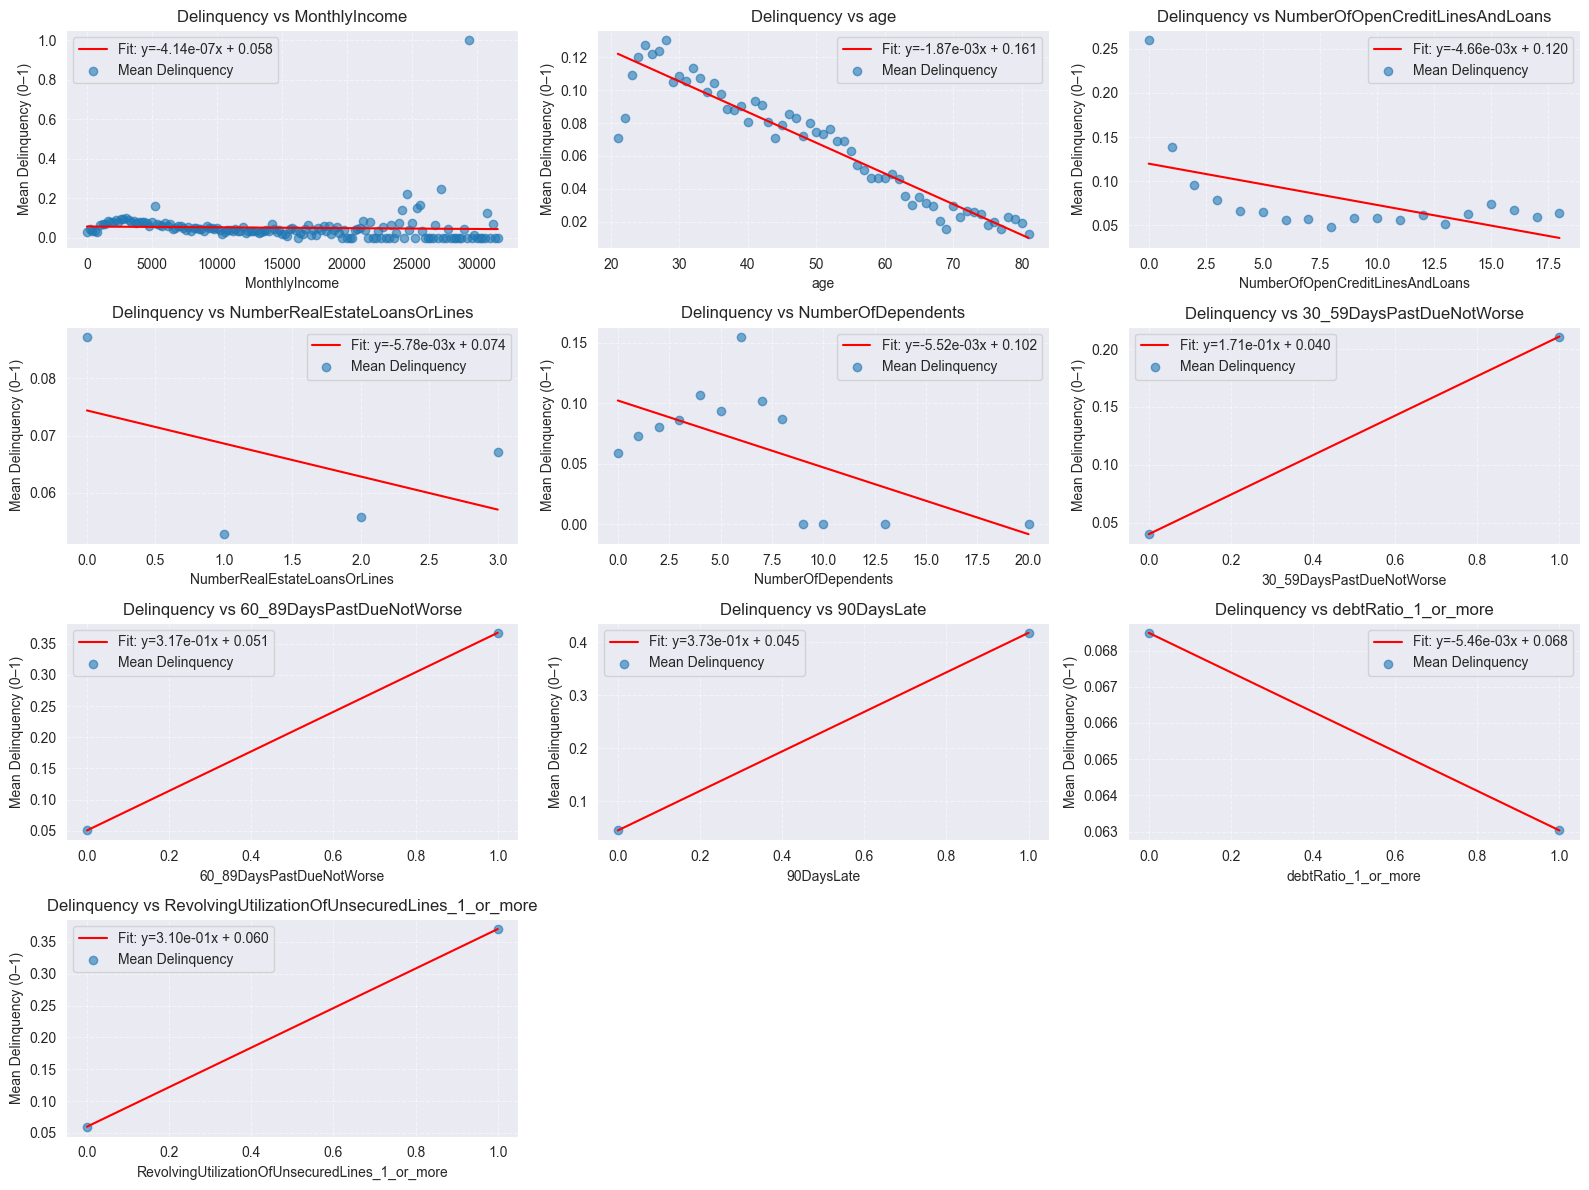

In [12]:
# Variables to analyze
vars_to_plot = [
    'MonthlyIncome',  # assuming you've filled nulls already
    'age',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'NumberOfDependents',
    '30_59DaysPastDueNotWorse',
    '60_89DaysPastDueNotWorse',
    '90DaysLate',
    'debtRatio_1_or_more',
    'RevolvingUtilizationOfUnsecuredLines_1_or_more'
]

plot_scatters(vars_to_plot, full_df_no_outliers)

### Let's do some more transformations to make these fits better

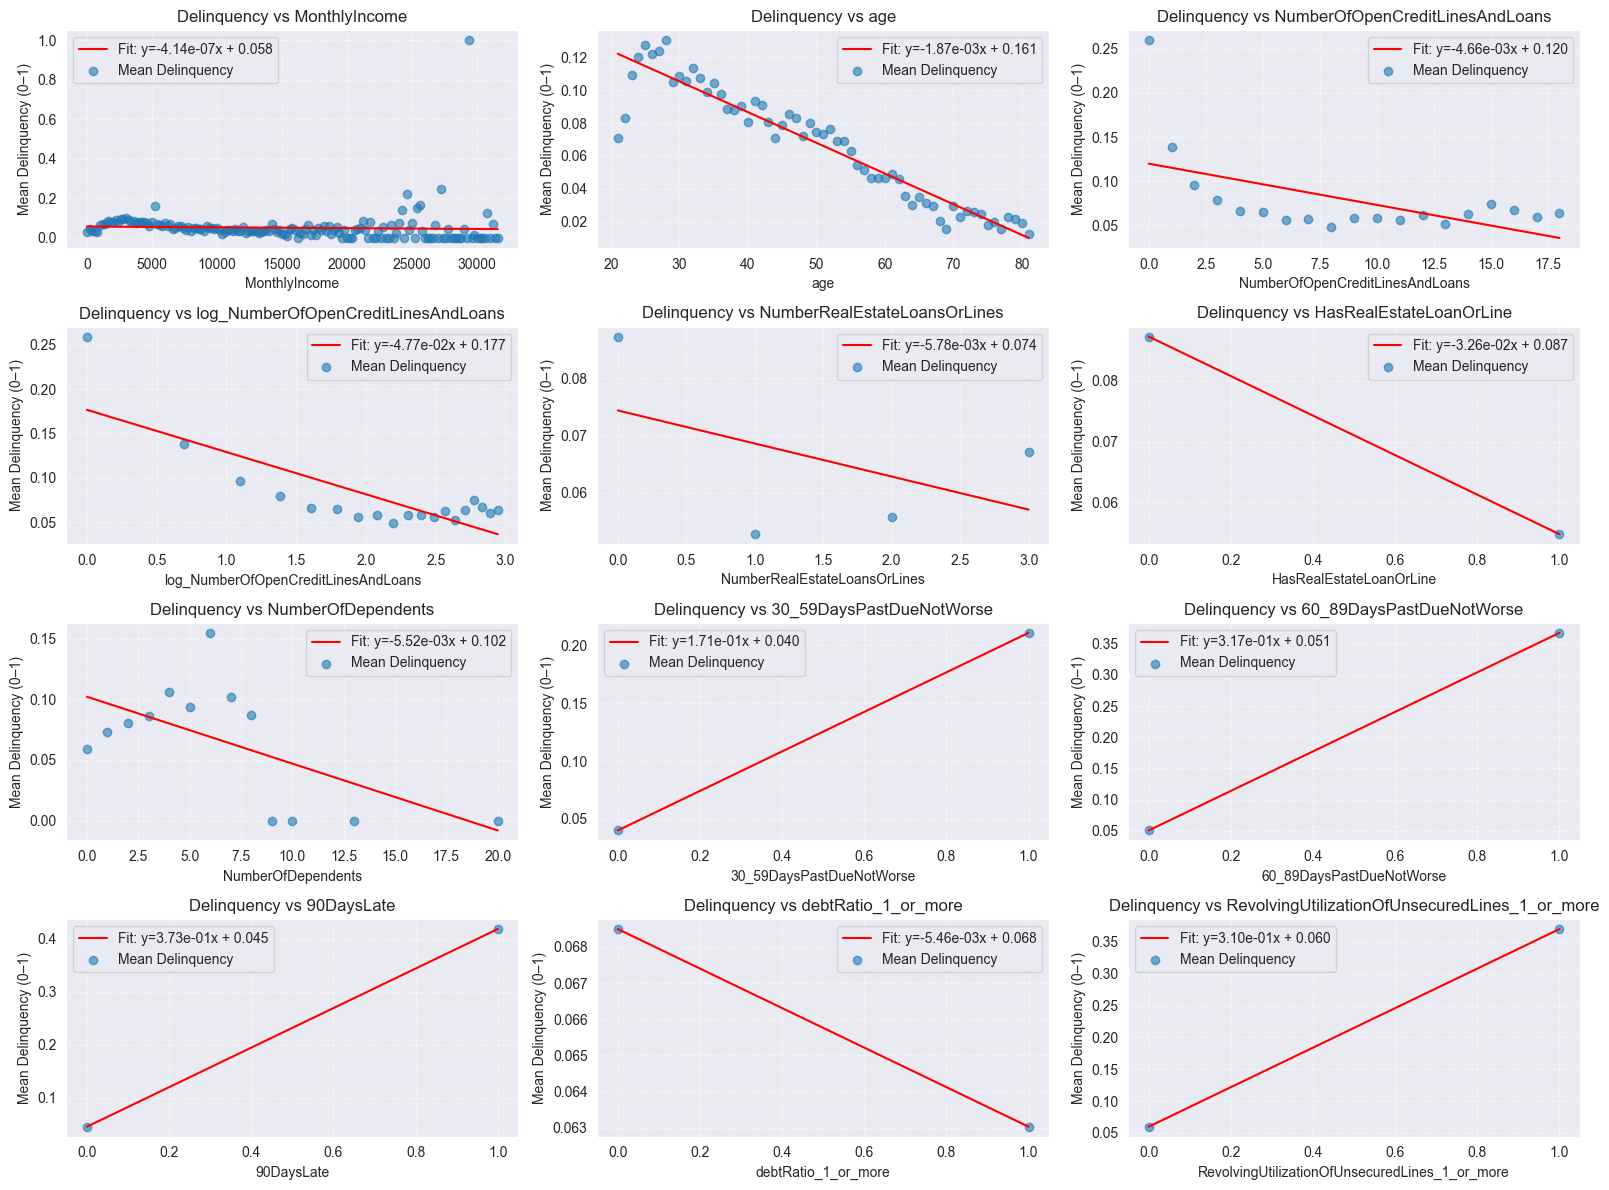

In [13]:
# Log transform NumberOfOpenCreditLinesAndLoans
full_df_no_outliers['log_NumberOfOpenCreditLinesAndLoans'] = np.log1p(full_df_no_outliers['NumberOfOpenCreditLinesAndLoans'])
full_df_no_outliers["HasRealEstateLoanOrLine"] = (full_df_no_outliers["NumberRealEstateLoansOrLines"] >= 1).astype(int)

vars_to_plot = [
    'MonthlyIncome',  # assuming you've filled nulls already
    'age',
    'NumberOfOpenCreditLinesAndLoans',
    'log_NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'HasRealEstateLoanOrLine',
    'NumberOfDependents',
    '30_59DaysPastDueNotWorse',
    '60_89DaysPastDueNotWorse',
    '90DaysLate',
    'debtRatio_1_or_more',
    'RevolvingUtilizationOfUnsecuredLines_1_or_more',
]

plot_scatters(vars_to_plot, full_df_no_outliers)

In [14]:
def apply_transformations(df):
    df = df.copy()
    df["NumberOfOpenCreditLinesAndLoans_log"] = np.log1p(df["NumberOfOpenCreditLinesAndLoans"])
    df["HasRealEstateLoanOrLine"] = (df["NumberRealEstateLoansOrLines"] >= 1).astype(int)
    df["30_59DaysPastDueNotWorse_flag"] = (df["NumberOfTime30-59DaysPastDueNotWorse"] > 0).astype(int)
    df["60_89DaysPastDueNotWorse_flag"] = (df["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int)
    df["90DaysLate_flag"] = (df["NumberOfTimes90DaysLate"] > 0).astype(int)
    df["debtRatio_1_or_more_flag"] = (df["DebtRatio"] >= 1).astype(int)
    df["RevolvingUtilizationOfUnsecuredLines_1_or_more_flag"] = (df["RevolvingUtilizationOfUnsecuredLines"] >= 1).astype(int)
    return df

def standardized_df_and_column_statistics_dict(df, column_names):
    # Create a copy to avoid modifying the original dataframe
    df_result = df.copy()

    # Initialize the statistics dictionary
    stats_dict = {}

    # Process each column
    for col in column_names:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in dataframe")

        # Calculate mean and std
        mean_val = df[col].mean()
        std_val = df[col].std()

        # Store statistics
        stats_dict[col] = {'mean': mean_val, 'std': std_val}

        # Create standardized column
        # Handle case where std is 0 to avoid division by zero
        if std_val == 0:
            df_result[f'std_{col}'] = 0
        else:
            df_result[f'std_{col}'] = (df[col] - mean_val) / std_val

    return df_result, stats_dict

In [15]:
full_df_transformed = apply_transformations(full_df)

# --- Define the list of features to standardize ---
FEATURES_TO_STANDARDIZE = [
    'NumberOfOpenCreditLinesAndLoans_log',
    'MonthlyIncome',
    'age',
    'NumberOfDependents',
    'NumberOfOpenCreditLinesAndLoans'
]

full_df_transformed_standardized, standardization_features_statistics =  standardized_df_and_column_statistics_dict(full_df_transformed, FEATURES_TO_STANDARDIZE)

STANDARDIZED_FEATURES = [f'std_{col}' for col in FEATURES_TO_STANDARDIZE]

full_df_transformed_standardized.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,30_59DaysPastDueNotWorse_flag,60_89DaysPastDueNotWorse_flag,90DaysLate_flag,debtRatio_1_or_more_flag,RevolvingUtilizationOfUnsecuredLines_1_or_more_flag,std_NumberOfOpenCreditLinesAndLoans_log,std_MonthlyIncome,std_age,std_NumberOfDependents,std_NumberOfOpenCreditLinesAndLoans
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,1,0,0,0,0,0.919834,0.25761,-0.493901,1.140535,0.883649
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,0,0,0,0,0,-0.800411,-0.242197,-0.832395,0.237209,-0.865295
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,1,0,1,0,0,-1.653877,-0.208314,-0.967793,-0.666117,-1.253949
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,0,0,0,0,0,-0.495796,-0.188536,-1.509384,-0.666117,-0.670968
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,1,0,0,0,0,-0.015149,4.432989,-0.223105,-0.666117,-0.282314


In [16]:
standardization_features_statistics

{'NumberOfOpenCreditLinesAndLoans_log': {'mean': np.float64(2.088508568714992),
  'std': np.float64(0.5985308431770631)},
 'MonthlyIncome': {'mean': np.float64(5759.464706431376),
  'std': np.float64(13045.043266196626)},
 'age': {'mean': np.float64(52.295555303702024),
  'std': np.float64(14.771297963552612)},
 'NumberOfDependents': {'mean': np.float64(0.7374049160327736),
  'std': np.float64(1.107020304618136)},
 'NumberOfOpenCreditLinesAndLoans': {'mean': np.float64(8.452776351842346),
  'std': np.float64(5.145964246011507)}}

### Logistic Regression

#### Train, test split

In [17]:
# Split into 70% training, 30% remaining
training_df, temp_df = train_test_split(full_df_transformed_standardized, test_size=0.3, random_state=42)

# Split the 30% portion into validation (20%) and test (10%)
validation_df, test_df = train_test_split(temp_df, test_size=(1/3), random_state=42)

# Reset indexes
training_df = training_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(training_df.shape)
print(validation_df.shape)
print(test_df.shape)

(104999, 29)
(30000, 29)
(15000, 29)


In [18]:
FLAG_FEATURES = ['30_59DaysPastDueNotWorse', '60_89DaysPastDueNotWorse',
                 '90DaysLate', 'debtRatio_1_or_more',
                 'RevolvingUtilizationOfUnsecuredLines_1_or_more']

X_FEATURES = STANDARDIZED_FEATURES + FLAG_FEATURES

Y_TARGET = 'SeriousDlqin2yrs'

# --- Separate X and Y for Training and Validation ---
X_train = training_df[X_FEATURES].copy()
Y_train = training_df[Y_TARGET].copy()
X_val = validation_df[X_FEATURES].copy()
Y_val = validation_df[Y_TARGET].copy()

# --- Convert all to standard numpy float64 ---
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
Y_train = Y_train.astype(np.float64)
Y_val = Y_val.astype(np.float64)

# Drop rows with NaN if any
if X_train.isna().any().any() or Y_train.isna().any():
    print("Dropping rows with NaN values...")
    mask = ~(X_train.isna().any(axis=1) | Y_train.isna())
    X_train = X_train[mask]
    Y_train = Y_train[mask]

if X_val.isna().any().any() or Y_val.isna().any():
    mask = ~(X_val.isna().any(axis=1) | Y_val.isna())
    X_val = X_val[mask]
    Y_val = Y_val[mask]

# --- Fit Logistic Regression using statsmodels for p-values ---
X_train_with_const = sm.add_constant(X_train)
logit_model = sm.Logit(Y_train, X_train_with_const)
result = logit_model.fit()

# Store the fitted model for later use
fitted_model = result

print("\nFull Statistical Summary:")
print(result.summary())

# --- Evaluate on Test Data (using the fitted model) ---
X_test = test_df[X_FEATURES].copy()
Y_test = test_df[Y_TARGET].astype(int)  # Ensure Y_test is explicitly integer type

# Convert test data to numpy float64
X_test = X_test.astype(np.float64)

# Add a constant term to the test data for prediction
X_test_with_const = sm.add_constant(X_test, has_constant='add')

# Get predictions (probabilities of belonging to class 1)
test_predictions_proba = fitted_model.predict(X_test_with_const)

# --- Calculate Binary Predictions (using a default threshold of 0.5) ---
THRESHOLD = 0.5
test_predictions_class = (test_predictions_proba >= THRESHOLD).astype(int)

# Calculate Precision and Recall
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

precision = precision_score(Y_test, test_predictions_class)
recall = recall_score(Y_test, test_predictions_class)
conf_matrix = confusion_matrix(Y_test, test_predictions_class)

print("\n--- Model Evaluation on Test Data (Threshold=0.5) ---")
print(f"Test Precision: {precision:.4f} (Of all predicted positives, how many were correct)")
print(f"Test Recall: {recall:.4f} (Of all actual positives, how many were correctly found)")
print("\nConfusion Matrix (Actual rows x Predicted columns):")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(Y_test, test_predictions_class))

print("\nNote on R-squared:")
print("The 'Pseudo R-squared' value above (Likelihood ratio R-squared) is the equivalent for Logistic Regression.")
print("The p-values in the 'P>|z|' column indicate the statistical significance of each feature.")

# For demonstration, printing the Pseudo R-squared value explicitly:
print(f"\nMcFadden's Pseudo R-squared (from Summary): {fitted_model.prsquared:.4f}")

Optimization terminated successfully.
         Current function value: 0.193522
         Iterations 8

Full Statistical Summary:
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               104999
Model:                          Logit   Df Residuals:                   104988
Method:                           MLE   Df Model:                           10
Date:                Wed, 05 Nov 2025   Pseudo R-squ.:                  0.2172
Time:                        21:12:16   Log-Likelihood:                -20320.
converged:                       True   LL-Null:                       -25957.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const    

### Bad Model
16% recall on class 1 So of all the customers who defaulted, I only identified 16% of them
54% precision on class 1, so of all the people I said would default, 52% of them actually did

Let's try something different

In [19]:
# Define columns and their aggregation methods
columns_to_analyze = [
    ('RevolvingUtilizationOfUnsecuredLines', 'median'),
    ('NumberRealEstateLoansOrLines', 'mean'),
    ('age', 'mean'),
    ('MonthlyIncome', 'mean'),
    ('DebtRatio', 'median'),
    ('NumberOfOpenCreditLinesAndLoans', 'median'),
    ('NumberOfDependents', 'mean'),
    ('NumberOfTimes90DaysLate', 'mean'),
    ('NumberOfTime60-89DaysPastDueNotWorse', 'mean'),
    ('NumberOfTime30-59DaysPastDueNotWorse', 'mean')
]

# Loop through each column
for column, agg_method in columns_to_analyze:
    stats_by_group = full_df.groupby('SeriousDlqin2yrs')[column].agg(agg_method)

    print(f"{agg_method.capitalize()} {column} by SeriousDlqin2yrs:")
    print(f"  SeriousDlqin2yrs = 0: {stats_by_group[0]:.4f}")
    print(f"  SeriousDlqin2yrs = 1: {stats_by_group[1]:.4f}")
    print()

Median RevolvingUtilizationOfUnsecuredLines by SeriousDlqin2yrs:
  SeriousDlqin2yrs = 0: 0.1333
  SeriousDlqin2yrs = 1: 0.8389

Mean NumberRealEstateLoansOrLines by SeriousDlqin2yrs:
  SeriousDlqin2yrs = 0: 1.0204
  SeriousDlqin2yrs = 1: 0.9885

Mean age by SeriousDlqin2yrs:
  SeriousDlqin2yrs = 0: 52.7518
  SeriousDlqin2yrs = 1: 45.9266

Mean MonthlyIncome by SeriousDlqin2yrs:
  SeriousDlqin2yrs = 0: 5789.4964
  SeriousDlqin2yrs = 1: 5340.1925

Median DebtRatio by SeriousDlqin2yrs:
  SeriousDlqin2yrs = 0: 0.3627
  SeriousDlqin2yrs = 1: 0.4282

Median NumberOfOpenCreditLinesAndLoans by SeriousDlqin2yrs:
  SeriousDlqin2yrs = 0: 8.0000
  SeriousDlqin2yrs = 1: 7.0000

Mean NumberOfDependents by SeriousDlqin2yrs:
  SeriousDlqin2yrs = 0: 0.7235
  SeriousDlqin2yrs = 1: 0.9313

Mean NumberOfTimes90DaysLate by SeriousDlqin2yrs:
  SeriousDlqin2yrs = 0: 0.1352
  SeriousDlqin2yrs = 1: 2.0914

Mean NumberOfTime60-89DaysPastDueNotWorse by SeriousDlqin2yrs:
  SeriousDlqin2yrs = 0: 0.1267
  SeriousDl

In [20]:
def add_pred_serious_dlq(df, threshold=2, conditions=None):
    df_copy = df.copy()

    # Default conditions if none provided
    if conditions is None:
        conditions = [
            {"col": "NumberOfTime30-59DaysPastDueNotWorse", "op": ">", "value": 0},
            {"col": "NumberOfTime60-89DaysPastDueNotWorse", "op": ">", "value": 0},
            {"col": "NumberOfTimes90DaysLate",            "op": ">", "value": 0},
        ]

    # Map string operators to actual functions
    ops = {
        '>': operator.gt,
        '>=': operator.ge,
        '<': operator.lt,
        '<=': operator.le,
        '==': operator.eq,
        '!=': operator.ne,
    }

    # Evaluate each condition
    condition_results = []
    for cond in conditions:
        col = cond['col']
        op_str = cond['op']
        val = cond['value']

        if op_str not in ops:
            raise ValueError(f"Unsupported operator: {op_str}. Use one of {list(ops.keys())}")

        result = ops[op_str](df_copy[col], val)
        condition_results.append(result)

    # Sum the number of True conditions per row
    points = pd.concat(condition_results, axis=1).sum(axis=1)

    # Apply final threshold
    df_copy["pred_SeriousDlqin2yrs"] = (points >= threshold).astype(int)

    return df_copy

In [21]:
# 1. High utilization + no income → extreme risk
full_df["HighUtil_NoIncome"] = (
    (full_df["RevolvingUtilizationOfUnsecuredLines"] >= 0.95) &
    (full_df["MonthlyIncome"] < 500)
).astype(int)

# 2. Young + high debt burden
full_df["Young_HighDebt"] = (
    (full_df["age"] < 25) &
    (full_df["DebtRatio"] >= 1.0)
).astype(int)

# 4. Overextended: high utilization + many open accounts
full_df["Overextended"] = (
    (full_df["RevolvingUtilizationOfUnsecuredLines"] >= 0.9) &
    (full_df["NumberOfOpenCreditLinesAndLoans"] >= 10)
).astype(int)

# 5. Real estate over-leveraged + low income
full_df["RE_LowIncome"] = (
    (full_df["NumberRealEstateLoansOrLines"] >= 2) &
    (full_df["MonthlyIncome"] < 3000)  # adjust based on data
).astype(int)

custom_conds = [
    {"col": "NumberOfTime30-59DaysPastDueNotWorse", "op": ">", "value": 0},
    {"col": "NumberOfTime60-89DaysPastDueNotWorse", "op": ">", "value": 0},
    {"col": "NumberOfTimes90DaysLate",              "op": ">", "value": 0},
    {"col": "RevolvingUtilizationOfUnsecuredLines", "op": ">=", "value": 0.95},
    {"col": "DebtRatio",                            "op": ">=", "value": 1.0},
    {"col": "MonthlyIncome",                        "op": "<", "value": 500},
    {"col": "HighUtil_NoIncome", "op": "==", "value": 1},
    {"col": "Young_HighDebt", "op": "==", "value": 1},
    {"col": "Overextended", "op": "==", "value": 1},
    {"col": "age",                                  "op": "<",  "value": 25},
    {"col": "NumberOfTime30-59DaysPastDueNotWorse", "op": ">=", "value": 2},
    {"col": "NumberOfTimes90DaysLate", "op": ">=", "value": 2},
    {"col": "NumberOfOpenCreditLinesAndLoans",      "op": ">=", "value": 15},
    {"col": "NumberRealEstateLoansOrLines",         "op": ">=", "value": 3},
]

def print_classification_report(df, thresholds, conditions):
    df_copy = df.copy()
    for t in thresholds:
        labeled_df = add_pred_serious_dlq(df_copy, t, conditions)
        y_true = labeled_df["SeriousDlqin2yrs"]
        y_pred = labeled_df["pred_SeriousDlqin2yrs"]
        report = classification_report(y_true, y_pred, target_names=['0', '1'])
        print(f"Classification Report for Threshold ({t}):")
        print(report)

print_classification_report(full_df, [1,2,3,4,5,6,7], custom_conds)

Classification Report for Threshold (1):
              precision    recall  f1-score   support

           0       0.98      0.48      0.64    139973
           1       0.11      0.86      0.19     10026

    accuracy                           0.50    149999
   macro avg       0.54      0.67      0.41    149999
weighted avg       0.92      0.50      0.61    149999

Classification Report for Threshold (2):
              precision    recall  f1-score   support

           0       0.97      0.76      0.85    139973
           1       0.16      0.67      0.26     10026

    accuracy                           0.75    149999
   macro avg       0.57      0.71      0.56    149999
weighted avg       0.92      0.75      0.81    149999

Classification Report for Threshold (3):
              precision    recall  f1-score   support

           0       0.96      0.93      0.94    139973
           1       0.31      0.46      0.37     10026

    accuracy                           0.90    149999
   ma

### Light GBM Time

In [22]:
# 1. Dependents per year of age
full_df["dependent_per_age"] = full_df["NumberOfDependents"] / full_df["age"]

# 2. Monthly income per year of age
full_df["dollar_per_age"] = full_df["MonthlyIncome"] / full_df["age"]

# 3. Real estate loans as a portion of total credit lines
full_df["realestate_portion_of_loans"] = (full_df["NumberRealEstateLoansOrLines"] / full_df["NumberOfOpenCreditLinesAndLoans"])

feature_cols = [
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfTimes90DaysLate",
    "NumberRealEstateLoansOrLines",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents",
    "dependent_per_age",
    "dollar_per_age",
    "realestate_portion_of_loans"
]

target = "SeriousDlqin2yrs"

# Split data (stratify on target to preserve class balance)
X = full_df[feature_cols]
y = full_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parameters tuned for imbalanced credit risk data
params = {
    'objective': 'binary',
    'metric': 'auc',  # AUC is key for imbalanced data
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'class_weight': 'balanced',  # Critical for imbalanced data
    'seed': 42
}

# Train model
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.869044
Early stopping, best iteration is:
[111]	valid_0's auc: 0.869327


AUC: 0.8693271910418632

Classification Report:
              precision    recall  f1-score   support

  No Default       0.94      0.99      0.97     27995
     Default       0.58      0.19      0.29      2005

    accuracy                           0.94     30000
   macro avg       0.76      0.59      0.63     30000
weighted avg       0.92      0.94      0.92     30000



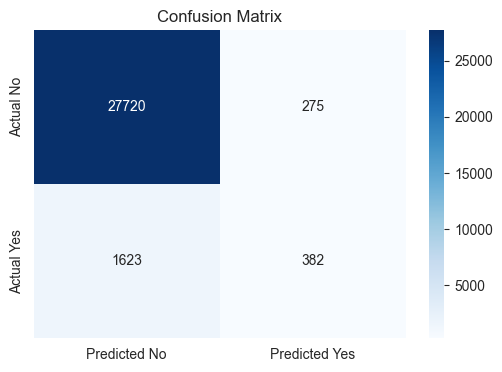

In [24]:
# Predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)  # You can tune this threshold!

# Metrics
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.show()

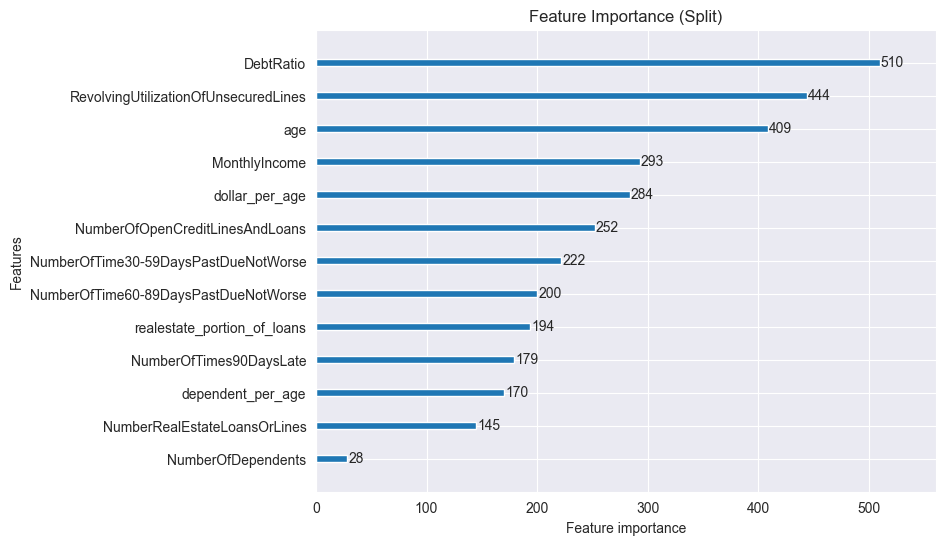


Top Features by Gain:
                                 feature    importance
6                NumberOfTimes90DaysLate  50063.659317
0   RevolvingUtilizationOfUnsecuredLines  49719.751707
2   NumberOfTime30-59DaysPastDueNotWorse  18953.321094
8   NumberOfTime60-89DaysPastDueNotWorse  10720.640976
3                              DebtRatio   5895.615993
1                                    age   5844.326472
5        NumberOfOpenCreditLinesAndLoans   3436.966260
4                          MonthlyIncome   3176.476455
11                        dollar_per_age   3081.896643
7           NumberRealEstateLoansOrLines   2697.059908


In [25]:
# Plot top features
lgb.plot_importance(model, max_num_features=20, figsize=(8,6))
plt.title("Feature Importance (Split)")
plt.show()

# Or get as DataFrame
importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance('gain')
}).sort_values('importance', ascending=False)

print("\nTop Features by Gain:")
print(importance_df.head(10))

In [26]:
# Try different thresholds
for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    y_pred_t = (y_pred_proba >= thresh).astype(int)
    rec = recall_score(y_test, y_pred_t)
    prec = precision_score(y_test, y_pred_t)
    print(f"Threshold {thresh:.1f} → Precision: {prec:.3f}, Recall: {rec:.3f}")

Threshold 0.1 → Precision: 0.275, Recall: 0.688
Threshold 0.2 → Precision: 0.397, Recall: 0.519
Threshold 0.3 → Precision: 0.468, Recall: 0.396
Threshold 0.4 → Precision: 0.536, Recall: 0.295
Threshold 0.5 → Precision: 0.581, Recall: 0.191
Threshold 0.6 → Precision: 0.650, Recall: 0.097
Threshold 0.7 → Precision: 0.747, Recall: 0.031
Threshold 0.8 → Precision: 1.000, Recall: 0.002


In [27]:
# Get feature importance from a full model
full_model = lgb.train(
    params,
    lgb.Dataset(X_train, y_train),
    valid_sets=[lgb.Dataset(X_test, y_test)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

importance_df = pd.DataFrame({
    'feature': full_model.feature_name(),
    'importance': full_model.feature_importance('gain')
}).sort_values('importance', ascending=False)

all_features = importance_df['feature'].tolist()
feature_configs = {
    'Top 5': all_features[:5],
    'Top 6': all_features[:6],
    'Top 7': all_features[:7],
    'All': all_features
}

thresholds = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8]

# Build results dictionary
results = []

for name, features in feature_configs.items():
    # Train model on subset
    train_data = lgb.Dataset(X_train[features], y_train)
    test_data = lgb.Dataset(X_test[features], y_test, reference=train_data)
    model_sub = lgb.train(
        params, train_data,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )

    y_pred_proba = model_sub.predict(X_test[features])

    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)

        results.append({
            'Threshold': thresh,
            f'{name} Precision': round(prec, 3),
            f'{name} Recall': round(rec, 3)
        })

# Convert to DataFrame and merge by threshold
df_results = pd.DataFrame(results)
df_table = df_results.groupby('Threshold').first().reset_index()

# Reorder columns to group precision/recall together
cols = ['Threshold']
for name in ['Top 5', 'Top 6', 'Top 7', 'All']:
    cols.extend([f'{name} Precision', f'{name} Recall'])

df_table = df_table[cols]

# Set Threshold as index for cleaner display
df_display = df_table.set_index('Threshold')

# Display
print("\nPrecision & Recall for Class '1' (Default) by Feature Set and Threshold")
print("="*80)
print(df_display.to_string())

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.869044
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[52]	valid_0's auc: 0.86123
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.866083
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.86906
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.868177

Precision & Recall for Class '1' (Default) by Feature Set and Threshold
           Top 5 Precision  Top 5 Recall  Top 6 Precision  Top 6 Recall  Top 7 Precision  Top 7 Recall  All Precision  All Recall
Threshold                                                                                                

I would pick the model with the top 6 features because the performance is super similar to the one with all variables, but it's faster compute time and less overfitting

Next, I want to prioritise precision because I can always ban users from using our service again if they have a default, but I can never recover customers that were misslabled as potential defaulter

However, I want to take the order size into account.

Let's assume that Paidy's profit margin is 5% and let p represent my threshold (propability of default)

Here is how I would select which threshold to use

The expected value (EV) of accepting a customer is:

$$
\text{EV} = (0.05) \cdot \text{ORDER\_SIZE} \cdot \text{Expected\_LIFETIME\_ORDERS} \cdot (1 - p) - \text{ORDER\_SIZE} \cdot p
$$

We approve the customer if:

$$
(0.05) \cdot \text{ORDER\_SIZE} \cdot \text{Expected\_LIFETIME\_ORDERS} \cdot (1 - p) - \text{ORDER\_SIZE} \cdot p > 0
$$

This can be simplified by factoring out `ORDER_SIZE`:

$$
\text{ORDER\_SIZE} \cdot \left[ 0.05 \cdot \text{Expected\_LIFETIME\_ORDERS} \cdot (1 - p) - p \right] > 0
$$

Since `ORDER_SIZE > 0`, the decision rule reduces to:

$$
0.05 \cdot \text{Expected\_LIFETIME\_ORDERS} \cdot (1 - p) > p
$$

We approve the customer if the predicted default probability $ p $ satisfies:

$$
p < \frac{0.05 \cdot \text{Expected\_LIFETIME\_ORDERS}}{0.05 \cdot \text{Expected\_LIFETIME\_ORDERS} + 1}
$$

This is the **maximum acceptable default risk** that still yields positive expected value.